# Notebook for Master's Thesis

_Jonatan Haraldsson_ [jonhara@chalmers.se](mailto:jonhara@chalmers.se)

_Jesper Noord_ [noord@chalmers.se](mailto:noord@chalmers.se)



In [2]:
# relevant modules for this notebook
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
import emcee
import corner
import scipy
from scipy.stats import gamma, invgamma, t, norm, norminvgauss, mode, uniform
import seaborn as sns
import random
import sklearn
import scipy.constants as const
import random
import tqdm
from tqdm import trange
import keras as keras
import tensorflow as tf

# import  settings
import plot_settings
plot_settings.apply()

np.random.seed(123)

In [3]:
import pybamm


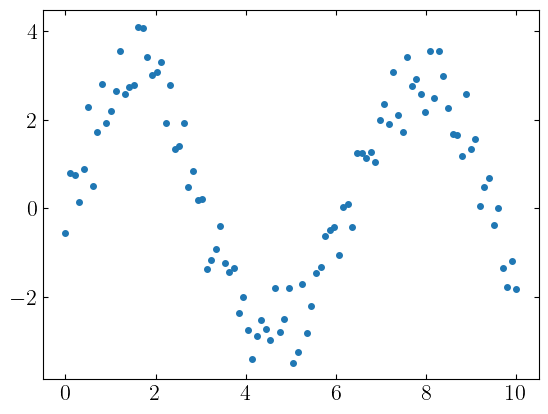

In [4]:
x = np.linspace(0, 10, 100)
y = 3 * np.sin(x) + np.random.normal(0, 0.5, size=x.shape)


plt.plot(x, y, 'o', markersize=4)